# Enhancing Sentinel-2 cloud masking with S2Cloudless

In general, S2cloudless provides a superior cloud mask to SCL and FMASK. However, it suffers from a high false positive rate over bright objects including white-sand beaches, urban areas, and mine sites.  

Here, we use the S2Cloudless probability layer to reduce false positives. With a reduced false positive rate, derivative S2 products like the geomedian can return a more representative image, and eliminate or reduce the number of NaNs in the final mosaic.


## Import libraries

In [1]:
import os
import warnings
import datacube
import xarray as xr
import numpy as np
import geopandas as gpd
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from odc.geo.geom import Geometry
from odc.algo import geomedian_with_mads
from odc.algo import xr_quantile
from odc.algo._masking import mask_cleanup

import sys
sys.path.insert(1, '/home/jovyan/git/dea-notebooks/Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb

warnings.filterwarnings("ignore")

In [2]:
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44059,Workers: 1
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:34901,Total threads: 31
Dashboard: /user/chad.burton@ga.gov.au/proxy/32901/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:37151,


## Analysis Parameters

In [3]:
region_code = ['x112y099'] #cape arid, esperance 

time='2022'
resolution=(-10,10)
mask_filters = [("opening", 4), ("dilation", 11)]
cp_threshold = 0.1
dask_chunks = dict(x=1000, y=1000)

## Set up dc query

In [4]:
#connect to dc
dc = datacube.Datacube(app='s2_gm_test')

# Create a reusable query
query = {
    'time': time,
    'resolution': resolution,
    'dask_chunks' : dask_chunks,
    'group_by': 'solar_day',
    'output_crs': 'EPSG:3577',
}

## Open tile and select

In [5]:
gdf = gpd.read_file('/home/jovyan/gdata1/projects/s2_gm/data/au_extended_s2_32km_grid.geojson')

gdf = gdf[gdf['region_code'].isin(region_code)]

geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
query.update({'geopolygon': geom})

In [6]:
gdf.explore(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
)

## Computer long-term cloud-probabilities and quantiles

The key aspect of our approach is to use long-term percentiles of the cloud-probability layer to determine regions that are persistently misclassified as cloud. If a cloud mask worked perfectly, we shouldn't be able identify land cover objects in a 10th percentile image of cloud-probability as the spatio-temporal distribution of clouds should not align with land cover (except in a coarse sense where, for example, clouds will preferentially appear along land-sea interfaces).  However, as we see in the figure a few cells below, the 10th percentile cloud probability aligns with beaches and sand dunes - bright, white objects that S2Cloudless repeatedly mistakes as clouds.

In [7]:
cp_probs = load_ard(dc=dc,
             products=['ga_s2am_ard_3', 'ga_s2bm_ard_3', 'ga_s2cm_ard_3'],
             measurements=['oa_s2cloudless_prob'],
             time=('2020','2022'),
             resolution=resolution,
             geopolygon=geom,
             dask_chunks=dask_chunks,
             group_by='solar_day',
             output_crs='EPSG:3577',
             cloud_mask='s2cloudless',
             resampling="nearest", #
             verbose=False,
             mask_pixel_quality=False,
             mask_contiguity=True,
             skip_broken_datasets=True,
            )


In [8]:
prob_quantiles = xr_quantile(cp_probs[['oa_s2cloudless_prob']].chunk(dict(time=-1)), quantiles=[0.1], nodata=np.nan).compute()

## Load S2 data

In [9]:
s2_masked = load_ard(dc=dc,
             products=['ga_s2am_ard_3', 'ga_s2bm_ard_3', 'ga_s2cm_ard_3'],
             measurements=['nbart_green', 'nbart_red', 'nbart_blue', 'oa_s2cloudless_mask'],
             cloud_mask='s2cloudless',
             resampling={"oa_s2cloudless_mask": "nearest", "*": "cubic"},
             verbose=False,
             mask_pixel_quality=True,
             mask_contiguity=True,
             skip_broken_datasets=True,
             **query
            )

s2_unmasked = load_ard(dc=dc,
             products=['ga_s2am_ard_3', 'ga_s2bm_ard_3', 'ga_s2cm_ard_3'],
             measurements=['nbart_green', 'nbart_red', 'nbart_blue', 'oa_s2cloudless_prob'],
             cloud_mask='s2cloudless',
             resampling={"oa_s2cloudless_prob": "nearest", "*": "cubic"},
             verbose=False,
             mask_pixel_quality=False,
             mask_contiguity=True,
             skip_broken_datasets=True,
             **query
            )

## Calculate standard geomedian

In [10]:
## Standard GM with no additional filtering
s2_gm_standard = geomedian_with_mads(
    s2_masked,
    reshape_strategy='mem',
    compute_mads=False
)

s2_gm_standard = assign_crs(s2_gm_standard.load(), crs='EPSG:3577')

### Plot GM along with cloud probs

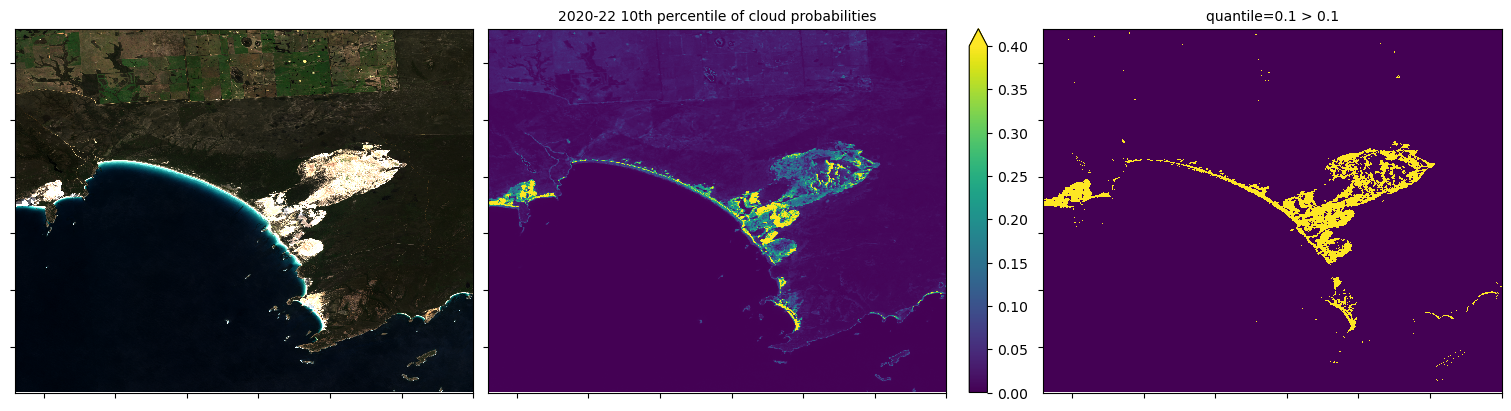

In [11]:
fig,ax = plt.subplots(1,3, figsize=(15,4), layout='constrained', sharey=True)

s2_gm_standard[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True, ax=ax[0], add_labels=False);
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

prob_quantiles['oa_s2cloudless_prob'].sel(quantile=0.1).plot.imshow(ax=ax[1], vmin=0, vmax=0.4, add_labels=False)
ax[1].set_title(f'2020-22 10th percentile of cloud probabilities', fontsize=10);
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

(prob_quantiles['oa_s2cloudless_prob'].sel(quantile=0.1) > 0.1).plot.imshow(ax=ax[2], add_labels=False, add_colorbar=False)
ax[2].set_title(f'quantile=0.1 > 0.1', fontsize=10)
ax[2].set_yticklabels([])
ax[2].set_xticklabels([]);

## Improved cloud masking with S2Cloudless probabilities

By exploiting the information in the cloud-probability layer, we will attempt to improve cloud classification as follows:

1. Compute long-term cloud probabilities (say three years), take the 10th percentile (as we already did above).
2. Apply window smoothing mean to annual time series of cloud probabilities, ~200*200m to mimic the convolution filter of default S2Cloudless.
3. Where 10th percentile cloud probabilities are greater than or equal to 0.1, Add 0.4 (the default threshold) to the long-term percentiles and this is the new cloud-probability threshold for those regions.
4. Clip the maximum threshold to 0.90
5. Apply opening and dilation morphological filtering using odc.algo `mask_filters`

In [12]:
# # select 10th CP percentiles after applying window smoothing
cp_10th_percentile = prob_quantiles['oa_s2cloudless_prob'].sel(quantile=0.1)

#Apply window smoothing filter
cp_smoothed = s2_unmasked['oa_s2cloudless_prob'].rolling(x=20, y=20, center=True, min_periods=1).mean()

# cloud mask for regions repeatedly misclassified as cloud 
bad_regions = xr.where(cp_10th_percentile>cp_threshold, True, False) 
bad_regions_proba = cp_smoothed.where(bad_regions)
bad_regions_proba_mask = xr.where(bad_regions_proba>=(cp_10th_percentile+0.4).clip(0, 0.90), True, False)

# cloud mask for regions NOT repeatedly misclassified as cloud (default 0.4 threshold)
good_regions_proba = cp_smoothed.where(~bad_regions)
good_regions_proba_mask = xr.where(good_regions_proba>0.4, True, False)

## Combine cloud masks
updated_cloud_mask = np.logical_or(
                bad_regions_proba_mask, good_regions_proba_mask
                        )

# apply morphological filters
updated_cloud_mask_filtered = mask_cleanup(updated_cloud_mask, mask_filters=mask_filters)

# Apply updated cloud mask to observations
s2_updated_masked = s2_unmasked[['nbart_green', 'nbart_red', 'nbart_blue']].where(~updated_cloud_mask_filtered)
s2_updated_masked = s2_updated_masked.drop_vars('quantile')

### Show algorithm using an individual time steps


In [13]:
time=38
# s2_unmasked['oa_s2cloudless_prob'].isel(time=range(36,48)).plot.imshow(col='time', col_wrap=6)

First, lets look at the RGB image, the standard S2Cloud mask, and the cloudd probabilities

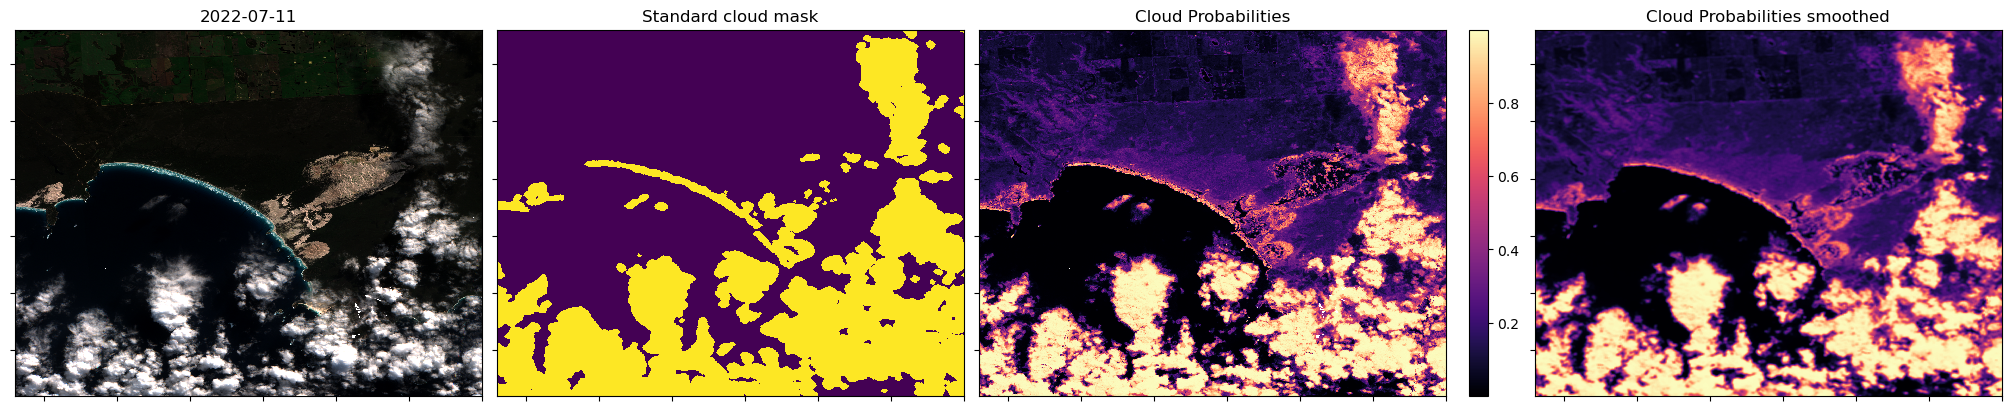

In [14]:
fig,ax = plt.subplots(1,4, figsize=(20,4), layout='constrained', sharey=True)

s2_unmasked[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=time).to_array().plot.imshow(robust=True, ax=ax[0], add_labels=False);
ax[0].set_title(s2_unmasked[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=time).time.values.astype(str)[0:10])
ax[0].set_yticklabels([])
ax[0].set_xticklabels([]);

s2_masked['oa_s2cloudless_mask'].isel(time=time).plot.imshow(ax=ax[1], add_labels=False, add_colorbar=False)
ax[1].set_title('Standard cloud mask')
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);

s2_unmasked['oa_s2cloudless_prob'].isel(time=time).plot.imshow(ax=ax[2],  add_labels=False, cmap='magma')
ax[2].set_title('Cloud Probabilities')
ax[2].set_yticklabels([])
ax[2].set_xticklabels([]);

cp_smoothed.isel(time=time).plot.imshow(ax=ax[3],  add_labels=False, cmap='magma', add_colorbar=False)
ax[3].set_title('Cloud Probabilities smoothed')
ax[3].set_yticklabels([])
ax[3].set_xticklabels([]);

Now, our algorithm splits the cloud mask into two regions, those identified as persistently misclassified as cloud ('bad' regions), and everywhere else. In the bad regions we have increased the cloud probability threshold at which at pixel is labelled as cloud.  In the worst regions, this new threshold will be close to 90 % (instead of the default threshold of 40 %).  

After separating out good from bad regions and applying different thresholds, when then combine the masks back together and apply morphological filters to further improve the cloud mask. On balance, opening=4 and dilation=11 appear to be appropriate.

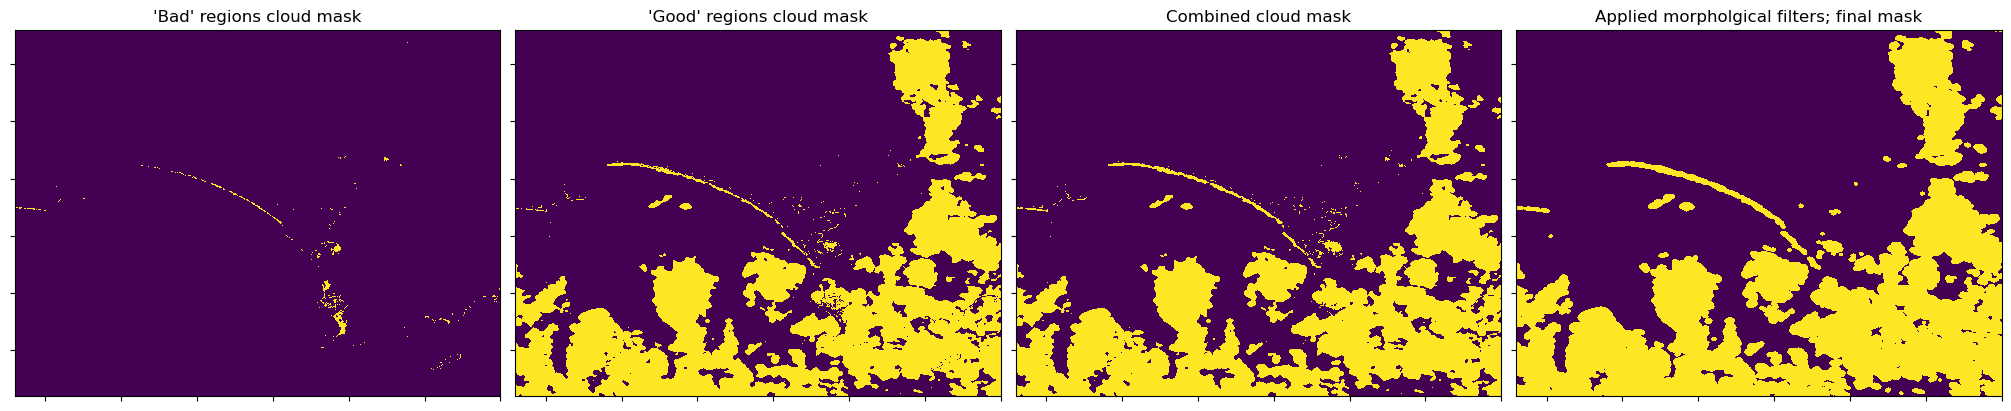

In [15]:
fig,ax = plt.subplots(1,4, figsize=(20,4), layout='constrained', sharey=True)

bad_regions_proba_mask.isel(time=time).plot.imshow(ax=ax[0],  add_labels=False, add_colorbar=False)
ax[0].set_title("'Bad' regions cloud mask")
ax[0].set_yticklabels([])
ax[0].set_xticklabels([]);

good_regions_proba_mask.isel(time=time).plot.imshow(ax=ax[1],  add_labels=False, add_colorbar=False)
ax[1].set_title("'Good' regions cloud mask")
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);

updated_cloud_mask.isel(time=time).plot.imshow(ax=ax[2],  add_labels=False, add_colorbar=False)
ax[2].set_title('Combined cloud mask')
ax[2].set_yticklabels([])
ax[2].set_xticklabels([]);

updated_cloud_mask_filtered.isel(time=time).plot.imshow(ax=ax[3],  add_labels=False, add_colorbar=False)
ax[3].set_title('Applied morpholgical filters; final mask')
ax[3].set_yticklabels([])
ax[3].set_xticklabels([]);

## Calculate geomedian with additional filtering

We have improved the cloud mask as best we can. Now we can use this new cloud mask to generate the geomedian

In [16]:
s2_gm_updated = geomedian_with_mads(
    s2_updated_masked,
    reshape_strategy='mem',
    compute_mads=False
)

s2_gm_updated = assign_crs(s2_gm_updated.load(), crs='EPSG:3577')

## Difference in clear counts

Comparing the clear counts between standard S2Cloudless masking and the algorithm applied here.

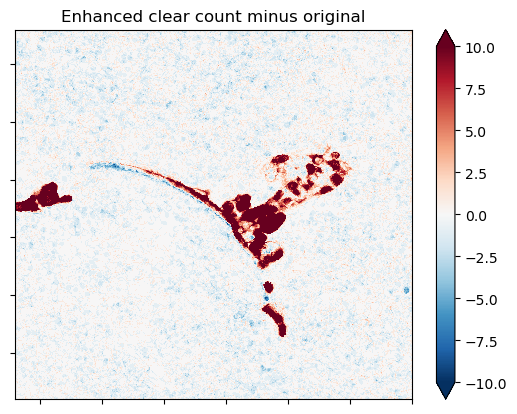

In [17]:
diff_count = (s2_gm_updated['count'].astype(np.float32) - s2_gm_standard['count'].astype(np.float32))
diff_count = assign_crs(diff_count, crs='EPSG:3577')

fig,ax=plt.subplots(1,1)
diff_count.plot.imshow(vmin=-10, vmax=10, cmap='RdBu_r', ax=ax, add_labels=False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Enhanced clear count minus original');

### Summary stats of clear counts

In [18]:
mean_clear_updated = s2_gm_updated['count'].mean().item()
mean_clear_standard = s2_gm_standard['count'].mean().item()

min_clear_updated = s2_gm_updated['count'].min().item()
min_clear_standard = s2_gm_standard['count'].min().item()

max_clear_updated = s2_gm_updated['count'].max().item()
max_clear_standard = s2_gm_standard['count'].max().item()

print(f'Updated masking clear counts (min, mean, max) = {min_clear_updated}, {mean_clear_updated:.0f}, {max_clear_updated}')
print(f'Standard masking clear counts (min, mean, max) = {min_clear_standard}, {mean_clear_standard:.0f}, {max_clear_standard}')

Updated masking clear counts (min, mean, max) = 6, 30, 40
Standard masking clear counts (min, mean, max) = 0, 30, 40


### Number of NaNs

In [19]:
for b in ['nbart_red', 'nbart_green', 'nbart_blue']:
    num_of_nans = np.sum(np.isnan(s2_gm_standard[b]))
    if num_of_nans>0:
        print(f'{num_of_nans.item()} NaNs present in standard masking {b}')
    else:
        print(f'standard masking {b} is clean')

for b in ['nbart_red', 'nbart_green', 'nbart_blue']:
    
    num_of_nans = np.sum(np.isnan(s2_gm_updated[b]))
    if num_of_nans>0:
        print(f'{num_of_nans.item()} NaNs present in enhanced masking {b}')
    else:
        print(f'enhanced masking {b} is clean')

5431 NaNs present in standard masking nbart_red
5431 NaNs present in standard masking nbart_green
5431 NaNs present in standard masking nbart_blue
enhanced masking nbart_red is clean
enhanced masking nbart_green is clean
enhanced masking nbart_blue is clean


### Make NaNs appear pink for plotting

In [20]:
# # Create a boolean mask where NaNs. Can do this on a single layer 
#  because we masked for contiguity
nan_mask = np.isnan(s2_gm_updated['nbart_red'])

# Loop over each band and assign the pink value where the pixel is NaN
#  10000 blue, 10000 red, 0 for green.
for var in s2_gm_updated.data_vars:
    if var=='nbart_red':
        s2_gm_updated[var] = xr.where(nan_mask, 10000, s2_gm_updated[var])
    if var=='nbart_blue':
        s2_gm_updated[var] = xr.where(nan_mask, 10000, s2_gm_updated[var])
    if var=='nbart_green':
        s2_gm_updated[var] = xr.where(nan_mask, 0, s2_gm_updated[var])
    
# Same again but now for S2Cloudless
nan_mask = np.isnan(s2_gm_standard['nbart_red'])

for var in s2_gm_standard.data_vars:
    if var=='nbart_red':
        s2_gm_standard[var] = xr.where(nan_mask, 10000, s2_gm_standard[var])
    if var=='nbart_blue':
        s2_gm_standard[var] = xr.where(nan_mask, 10000, s2_gm_standard[var])
    if var=='nbart_green':
        s2_gm_standard[var] = xr.where(nan_mask, 0, s2_gm_standard[var])

## Plot

Finally, let's compare the geomedians between the two approaches to cloud masking.

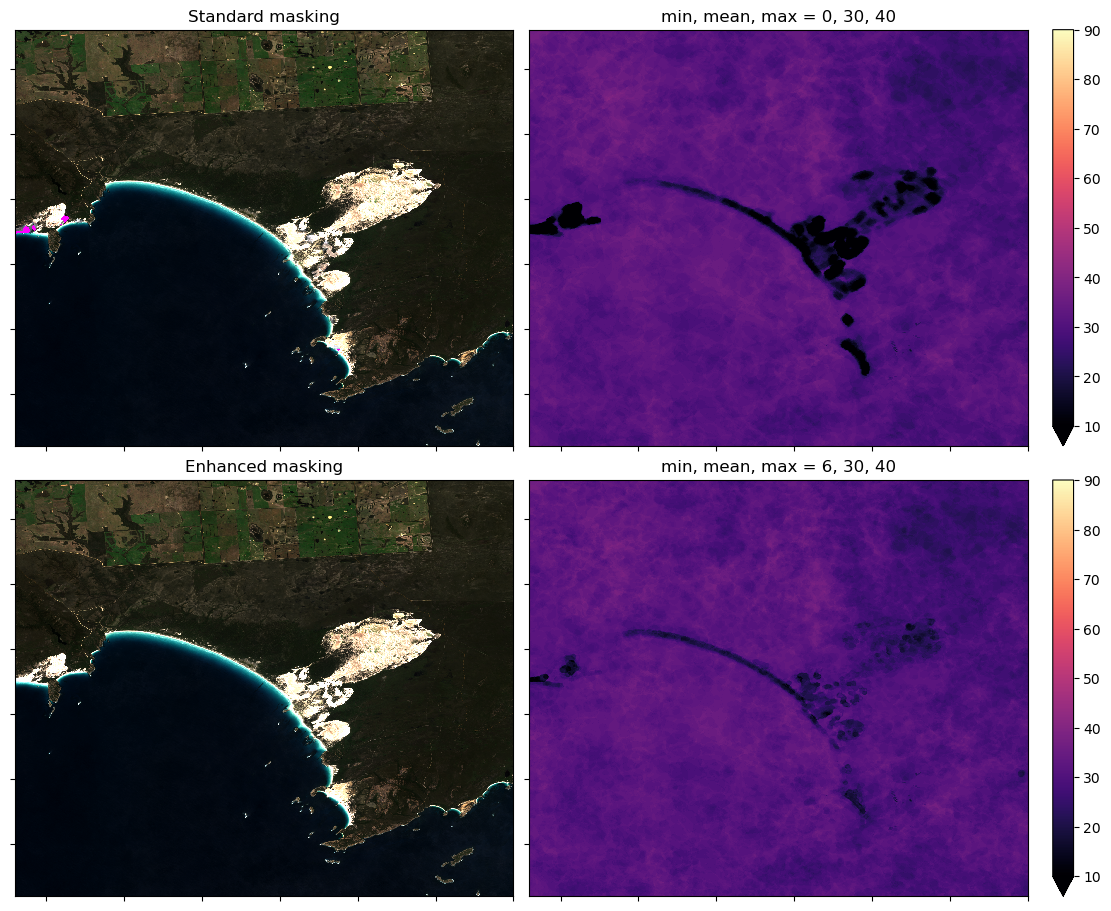

In [21]:
fig,ax = plt.subplots(2,2, figsize=(11,9), layout='constrained')
vmin, vmax=10, 90

#--------standard------------------------------
s2_gm_standard[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True, ax=ax[0,0], add_labels=False);
s2_gm_standard['count'].plot.imshow(vmin=vmin, vmax=vmax, cmap='magma', ax=ax[0,1], add_labels=False);

ax[0,0].set_title(f'Standard masking')
ax[0,1].set_title(f'min, mean, max = {min_clear_standard}, {mean_clear_standard:.0f}, {max_clear_standard}')

ax[0,0].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([]);

#--------updated------------------------------
s2_gm_updated[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True, ax=ax[1,0], add_labels=False);
s2_gm_updated['count'].plot.imshow(vmin=vmin, vmax=vmax, cmap='magma', ax=ax[1,1], add_labels=False);

ax[1,0].set_title(f'Enhanced masking')
ax[1,1].set_title(f'min, mean, max = {min_clear_updated}, {mean_clear_updated:.0f}, {max_clear_updated}')

ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([]);

# plt.savefig(f'/gdata1/projects/s2_gm/results/processed_figs/s2_gm_annual_{region_code[0]}_improvedcloudmasking.png', bbox_inches='tight', dpi=300);